## Precinct voters maps

My goal was to analyze the voters in a precinct: specifically, what addresses don't have recorded votes. I used three data sets to construct this analysis:

* Properties and streets from the [Durham ArcGIS server](http://gisweb2.durhamnc.gov/ArcGIS/rest/services/PublicWorks/PublicWorks/MapServer). Here is an example of the fields that each record has: [record 1](http://gisweb2.durhamnc.gov/ArcGIS/rest/services/PublicWorks/PublicWorks/MapServer/89/1)
* [Voter registration logs](http://dl.ncsbe.gov/index.html?prefix=data/) from the State Board of Elections.
* Precinct boundaries from the State Board of Elections.

The Durham ArcGIS platform returns a rectangle of properties. I only want properties within the precinct area, so I made an intersection with the precinct boundary to filter out non-precinct properties.

*Notes*: I use the form `test -f file || get file` to prevent re-running commands. You can delete the files to redownload. I used the [GDAL](http://www.gdal.org/ogr2ogr.html) package for some shapefile conversions (this could probably be converted to geopandas). All python dependencies, including jupyter, are listed in `requirements.txt`. Use the following to set work on this notebook yourself:

```
# install GDAL, however you do that on your platform. On OSX, you can install with homebrew (brew install gdal).

mkvirtualenv nc_election -p `which python3`
pip install -r requirements.txt
```

In [1]:
from arcgis import downloader, utils
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import os
import pandas as pd


matplotlib.style.use('ggplot')
%matplotlib inline

PRECINCT = '21'
%env PRECINCT=$PRECINCT

env: PRECINCT=21


In [2]:
!test -f data/Precincts.shp || ( wget https://s3.amazonaws.com/dl.ncsbe.gov/PrecinctMaps/SBE_PRECINCTS_20161004.zip && unzip SBE_PRECINCTS_20161004.zip )

In [3]:
!test -f data/precinct-$PRECINCT.shp || ogr2ogr -sql "select * from Precincts where COUNTY_NAM='DURHAM' and PREC_ID='$PRECINCT'" -t_srs EPSG:4326 precinct-$PRECINCT.shp Precincts.shp

In [4]:
!ogr2ogr -f geojson data/precinct-$PRECINCT.geojson data/precinct-$PRECINCT.shp

ERROR 6: The GeoJSON driver does not overwrite existing files.
geojson driver failed to create data/precinct-21.geojson


In [5]:
precinct = gpd.GeoDataFrame.from_file("data/precinct-{}.shp".format(PRECINCT))
bounds = precinct.bounds

all_lots_url_template = "http://gisweb2.durhamnc.gov/arcgis/rest/services/PublicWorks/PublicWorks/MapServer/89/query?f=json&geometry={},{},{},{}&returnGeometry=true&outFields=*&outSR=4326&inSR=4326"
lots = downloader.get_shp(all_lots_url_template, 'data/all_lots-{}'.format(PRECINCT), bounds)

highways_url_template = "http://gisweb2.durhamnc.gov/arcgis/rest/services/PublicWorks/PublicWorks/MapServer/54/query?f=json&geometry={},{},{},{}&returnGeometry=true&outFields=*&outSR=4326&inSR=4326"
highways = downloader.get_shp(highways_url_template, 'data/highways-{}'.format(PRECINCT), bounds)

streets_url_template = "http://gisweb2.durhamnc.gov/arcgis/rest/services/PublicWorks/PublicWorks/MapServer/56/query?f=json&geometry={},{},{},{}&returnGeometry=true&outFields=*&outSR=4326&inSR=4326"
streets = downloader.get_shp(streets_url_template, 'data/streets-{}'.format(PRECINCT), bounds)

In [6]:
print('Properties from arcgis boundary: {}'.format(len(lots)))

precinct = precinct.to_crs({'init': 'epsg:4326'})

lots_in_precinct = gpd.sjoin(lots, precinct, op='within')

print('Properties in precinct {}: {}'.format(PRECINCT, len(lots_in_precinct)))

lots_in_precinct.to_file('precinct-{}-lots.shp'.format(PRECINCT))

Properties from arcgis boundary: 1474
Properties in precinct 21: 1190


In [7]:
!rm -f data/precinct-$PRECINCT-lots.geojson && ogr2ogr -f geojson data/precinct-$PRECINCT-lots.geojson data/precinct-$PRECINCT-lots.shp

In [15]:
!test -f data/ncvoter32.zip && cd data && wget https://s3.amazonaws.com/dl.ncsbe.gov/data/ncvoter32.zip && unzip ncvoter32.zip

In [8]:
voters = pd.read_csv('data/ncvoter32.txt', sep=None)

/Users/danesummers/.virtual_env/nc_election/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [9]:
voters_in_precinct = voters[voters.county_desc=="DURHAM"]
voters_in_precinct = voters_in_precinct[voters_in_precinct.precinct_desc==PRECINCT]

RES                          1024
COM                            57
VAC RES                        43
VACANT COMMUNITY SERVICE       22
WILD                           13
VACANT COMMERCIAL              12
CMNTY SVC                      11
PUBL SVC                        3
VACANT PUBLIC UTILITY           2
WILD-FRST-CONS LD(UNDIFF)       1
VACANT LAND (UNDIFF)            1
REC                             1
Name: LANDUSE_CODE, dtype: int64

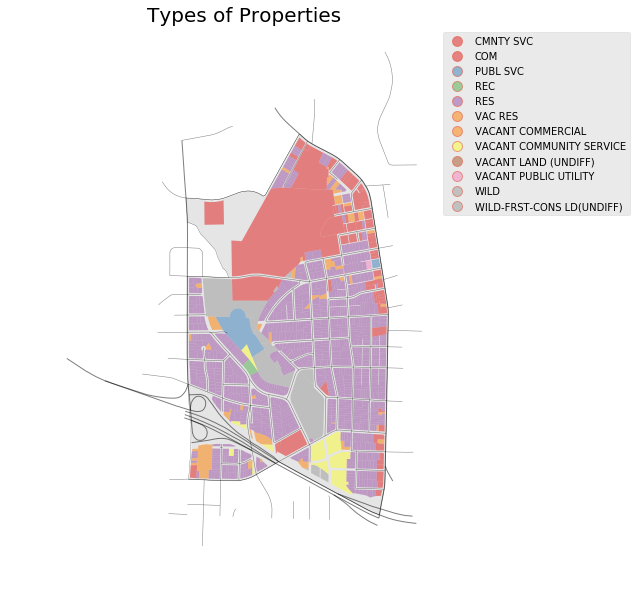

In [10]:
all_lots_pd = gpd.read_file('data/precinct-{}-lots.shp'.format(PRECINCT))
precinct_boundary_pd = gpd.read_file('data/precinct-{}.shp'.format(PRECINCT))

all_lots_pd['LANDUSE_CODE'] = all_lots_pd['LANDUSE_DE'].str.replace(r'/.*$','')


fig, ax = plt.subplots(1, figsize=(7,10))
precinct_boundary_pd.plot(ax=ax, color='black', alpha=0.1, linewidth=0.2)
streets.plot(ax=ax, color='black', edgecolor='black', alpha=0.5, linewidth=0.5)
highways.plot(ax=ax, color='black', edgecolor='black', alpha=0.5)

all_lots_pd.plot(ax=ax, column='LANDUSE_CODE', linewidth=0, legend=True)
ax.axis('off')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1., 0.5, 0.0))
plt.title('Types of Properties', fontsize=20)

all_lots_pd['LANDUSE_CODE'].value_counts()

In [11]:
# so now that I have a shapefile of residential addresses, lets make files of addresses
# with no voters:

# remove apartment numbers from addresses, to match up more addresses.
# TODO it might be possible to determine how many addresses have multiple tenants and use this apartment
# number to determine which apartments have no registered addresses:
utils.create_address_fields(voters_in_precinct, 'mail_addr1')
utils.create_address_fields(all_lots_pd, 'SITE_ADDRE')

voters_in_precinct['clean_number_address'] = voters_in_precinct['clean_street_number'] + ' ' + voters_in_precinct['clean_street_name']
all_lots_pd['clean_number_address'] = all_lots_pd['clean_street_number'] + ' ' + all_lots_pd['clean_street_name']

matched_regs = all_lots_pd.query('clean_number_address in @voters_in_precinct.clean_number_address')
non_matched_props = all_lots_pd.query('clean_number_address not in @voters_in_precinct.clean_number_address')
non_matched_regs = voters_in_precinct.query('clean_number_address not in @all_lots_pd.clean_number_address')

# filter out properties that are definitely NOT residential:
non_matched_props = non_matched_props[non_matched_props.LANDUSE_DE.str.startswith('COM') != True]
non_matched_props = non_matched_props[non_matched_props.LANDUSE_DE.str.startswith('WILD') != True]
non_matched_props = non_matched_props[non_matched_props.LANDUSE_DE.str.startswith('CMNTY SVC') != True]
non_matched_props = non_matched_props[non_matched_props.LANDUSE_DE.str.startswith('PUBL SVC') != True]
non_matched_props = non_matched_props[non_matched_props.LANDUSE_DE.str.startswith('VACANT') != True]
non_matched_props = non_matched_props[non_matched_props.LANDUSE_DE.str.startswith('VAC RES') != True]
non_matched_props = non_matched_props[non_matched_props.LANDUSE_DE.str.startswith('REC/ SOCIAL ORGANIZATIONS') != True]

# all_lots_pd[['SITE_ADDRE','LANDUSE_DE']][all_lots_pd['SITE_ADDRE'].str.contains('23 N ROXBORO')]
# lots[['SITE_ADDRE','LANDUSE_DE']][lots['SITE_ADDRE'].str.contains('3523')]
# lots[['SITE_ADDRE','LANDUSE_DE']][lots.LANDUSE_DE == 'COM/ APARTMENT-GARDEN']

# top ten addresses with registered voters (but couldn't find them on the map):
# non_matched_regs['mail_addr1'].value_counts()[:10]

## Joining Parcels to Voter Registrations

Joining properties to voter registration is not exact. I joined the data sets by their address. Since property parcels don't hove apartment numbers, I created a new field by stripping out the apartment number before joining. What we're left with are three data sets:

 * Joined data: a match between a voter registration and and address. Of course there can be as many of these as there are registered voters at the address.
 * Properties without voters: these could be commercial properties, park properties, or unregistered voters. After joining all property addresses to voter logs, I removed the commercial/park/city properties as these are not likely to have voters living at the address.
 * Voter registrations without an address match: These really should have a match - the focus going forward should be in reducing this number as much as possible! I've found these can be voters that live in apartments (I've found one instance where the property address of an apartment complex was different than the actual apartment addresses - I've found another city run API that returns all apartments #s for an address...this might be one way of getting at these voters). It may be that some addresses are considered to be in the precinct, even if they don't fall within the precinct boundary. Further analysis is needed.

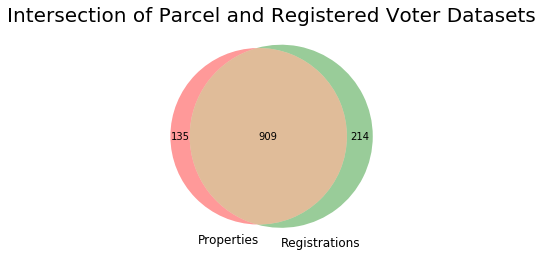

In [12]:
venn2(subsets = (len(non_matched_props), len(non_matched_regs), len(matched_regs)), set_labels=('Properties', 'Registrations'))
plt.title('Intersection of Parcel and Registered Voter Datasets', fontsize=20)
# all_lots_pd[['SITE_ADDRE','LANDUSE_DE']][all_lots_pd['SITE_ADDRE'].str.contains('3529 N ROXBORO ')]
# voters_in_precinct[['mail_addr1', 'absent_ind']][voters_in_precinct['mail_addr1'].str.contains('711 E HUDSON')]
# non_matched_regs['mail_addr1'].value_counts()

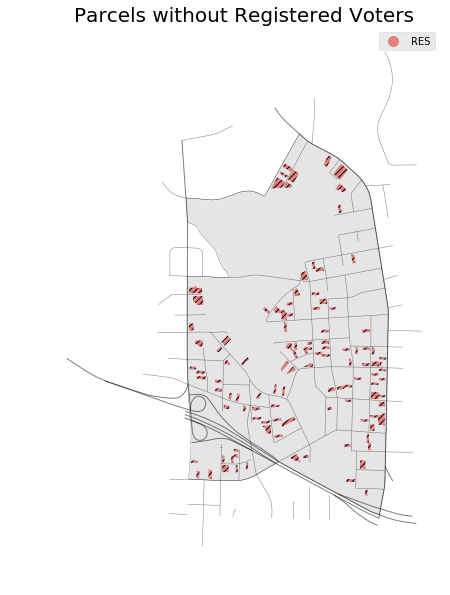

In [13]:
fig, ax = plt.subplots(1, figsize=(7,10))
precinct_boundary_pd.plot(ax=ax, color='black', alpha=0.1, linewidth=0.2)
streets.plot(ax=ax, color='black', edgecolor='black', alpha=0.5, linewidth=0.5)
highways.plot(ax=ax, color='black', edgecolor='black', alpha=0.5)
non_matched_props.plot(ax=ax, column='LANDUSE_CODE', edgecolor='none', legend=True, hatch='////')
ax.axis('off')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1., 0.0, 0.0))
plt.title('Parcels without Registered Voters', fontsize=20)

/Users/danesummers/.virtual_env/nc_election/lib/python3.5/site-packages/geopandas/plotting.py:414: SyntaxWarning: Only specify one of 'column' or 'color'. Using 'color'.
  SyntaxWarning)


Voter breakdown:


DEM    950
UNA    476
REP    128
LIB      5
Name: party_cd, dtype: int64

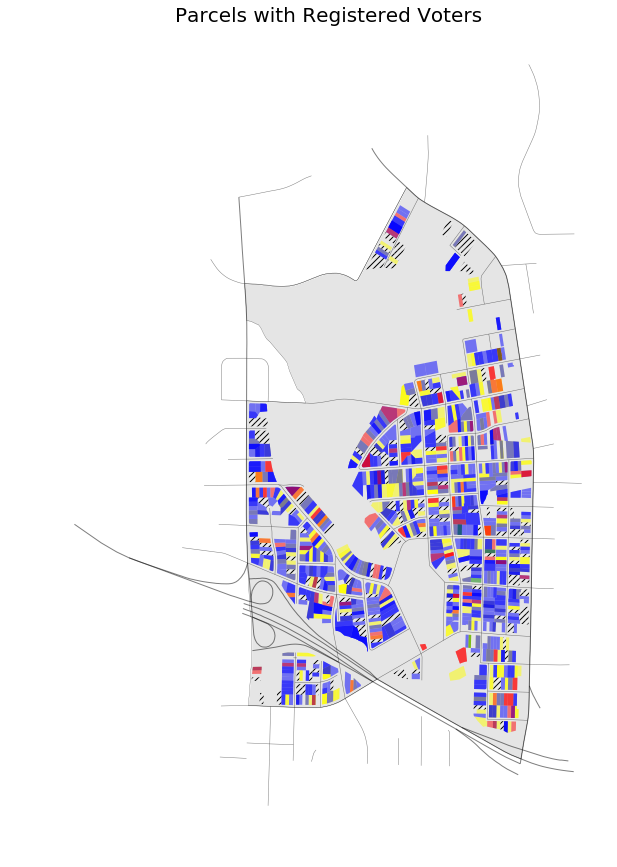

In [14]:
# and by party. Note that some places are super blue/red (all blue/red voters in the house).
# Purple for mixed houses, etc.

voters_pd = all_lots_pd.merge(voters_in_precinct,left_on='SITE_ADDRE',right_on='mail_addr1')

colors = {
    'DEM': 'blue',
    'LIB': 'green',
    'REP': 'red',
    'UNA': 'yellow'
}

fig, ax = plt.subplots(1, figsize=(10,15))
ax.axis('off')

# plot the boundary file and the properties without voters:
precinct_boundary_pd.plot(ax=ax, color='black', alpha=0.1, linewidth=0.2)
streets.plot(ax=ax, color='black', edgecolor='black', alpha=0.5, linewidth=0.5)
highways.plot(ax=ax, color='black', edgecolor='black', alpha=0.5)
non_matched_props.plot(ax=ax, color='#eeeeee', edgecolor='none', hatch='////')

# then plot each voter:
for k,v in colors.items():
    voters_pd[voters_pd.party_cd==k].plot(
        ax=ax, column='party_cd', linewidth=0, alpha=0.5, color=v
    )

plt.title('Parcels with Registered Voters', fontsize=20)
    
print("Voter breakdown:")
voters_pd['party_cd'].value_counts()